In [73]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add

In [28]:
def readText(path):
    with open(path) as f:
        captions = f.read()
        
    return captions

In [3]:
caption_line = readText('./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt')
caption_line = caption_line.split('\n')
caption_line = caption_line[:-1]

In [4]:
len(caption_line)

40460

In [5]:
caption_line[1].split('\t')

['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']

In [6]:
captions = {}

for caption in caption_line:
    first,second = caption.split('\t')
    name = first.split('.')[0]
    cap = second
    
    if captions.get(name) is None:
        captions[name] = []
        
    captions[name].append(cap)

In [7]:
captions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [8]:
def clean_text(sentence):
    sentence = sentence.lower()
    sentence = re.sub("[^a-z]+"," ",sentence)
    sentence = sentence.split()
    
    sentence  = [s for s in sentence if len(s)>1]
    sentence = " ".join(sentence)
    return sentence

# Clean all Captions
for key,caption_list in captions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])


In [9]:
captions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [10]:
with open("captions.txt","w") as f:
    f.write(str(captions))


In [3]:
captions = None
with open("captions.txt",'r') as f:
    captions = f.read()
    
json_acceptable_string = captions.replace("'","\"")
captions = json.loads(json_acceptable_string)


In [4]:
captions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [5]:
vocab = set()
for key in captions.keys():
    [vocab.update(sentence.split()) for sentence in captions[key]]
    
print("Vocab Size : %d"% len(vocab))

Vocab Size : 8424


In [6]:
# Total No of words across all the sentences
total_words = []

for key in captions.keys():
    [total_words.append(i) for des in captions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [7]:
import collections

counter = collections.Counter(total_words)
freq_cnt = dict(counter)
print(len(freq_cnt.keys()))

8424


In [8]:
sorted_freq_cnt = sorted(freq_cnt.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]


In [21]:
len(total_words)

1845

In [29]:
train_file_data = readText("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readText("./Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [30]:
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]

In [31]:
train[:5]

['2513260012_03d33305cf',
 '2903617548_d3e38d7f88',
 '3338291921_fe7ae0c8f8',
 '488416045_1c6d903fe0',
 '2644326817_8f45080b87']

In [32]:
len(test)

1000

In [33]:
train_captions = {}

for img_id in train:
    train_captions[img_id] = []
    for cap in captions[img_id]:
        cap_to_append = "startseq "  + cap + " endseq"
        train_captions[img_id].append(cap_to_append)

In [34]:
train_captions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [36]:
model = ResNet50(weights="imagenet",input_shape=(224,224,3))
model.summary()

102858752/102853048 [==============================] - 235s 2us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
______________________

In [37]:
model_new = Model(model.input,model.layers[-2].output)

In [38]:
def preprocess_img(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return img

def encode_image(img):
    img = preprocess_img(img)
    feature_vector = model_new.predict(img)
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector


In [41]:
IMG_PATH = './Flickr_Data/Flickr_Data/Images'
start = time()
encoding_train = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%1000==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

with open("encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)
    
    
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%500==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

with open("encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

Encoding in Progress Time step 0 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 3000 
Encoding in Progress Time step 4000 
Encoding in Progress Time step 5000 
Total Time Taken : 2303.786574602127
Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 500 
Total Time Taken(test) : 397.9177215099335


In [43]:
len(total_words)

1845

In [70]:
encoding_train = pickle.load(open('./encoded_train_features.pkl','rb'))
encoding_test = pickle.load(open('./encoded_test_features.pkl','rb'))

In [15]:
word_to_idx = {}
idx_to_word = {}

for i,word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

    
# Two special words
idx_to_word[1846] = 'startseq'
word_to_idx['startseq'] = 1846

idx_to_word[1847] = 'endseq'
word_to_idx['endseq'] = 1847

vocab_size = len(word_to_idx) + 1
print("Vocab Size",vocab_size)

Vocab Size 1848


In [35]:
max_len = 0 
for key in train_captions.keys():
    for cap in train_captions[key]:
        max_len = max(max_len,len(cap.split()))
        
print(max_len)

35


In [74]:
def data_generator(train_captions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_captions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

In [37]:
import gensim
from gensim.models import word2vec
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin',binary=True)

In [75]:
def get_embedding_matrix():
    emb_dim = 300
    matrix = np.zeros((vocab_size,emb_dim))
    for word,idx in word_to_idx.items():
        try:
            embedding_vector = word_vectors.get_vector(word)
            matrix[idx] = embedding_vector
        except KeyError:
            pass
            
    return matrix

In [76]:
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape


(1848, 300)

In [77]:
input_img_features = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_features)
inp_img2 = Dense(256,activation='relu')(inp_img1)

In [95]:
input_captions = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size,output_dim=300,mask_zero=True)(input_captions)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [96]:
decoder1 = add([inp_img2,inp_cap3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation='softmax')(decoder2)

# Combined Model
model = Model(inputs=[input_img_features,input_captions],outputs=outputs)

In [97]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 35, 300)      554400      input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_5[0][0]                    
____________________________________________________________________________________________

In [98]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [99]:
model.compile(loss='categorical_crossentropy',optimizer="adam")

In [100]:
epochs = 20
batch_size = 3
steps = len(train_captions)//3

In [101]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_captions,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        if i==19 or i ==10:
            model.save('./model_'+str(i)+'.h5')

In [102]:
train()

Epoch 1/1
2000/2000 [==============================] - 1643s 821ms/step - loss: 4.1173
Epoch 1/1
2000/2000 [==============================] - 1856s 928ms/step - loss: 3.3555
Epoch 1/1
2000/2000 [==============================] - 1608s 804ms/step - loss: 3.0996
Epoch 1/1
2000/2000 [==============================] - 1716s 858ms/step - loss: 2.9394
Epoch 1/1
1442/2000 [====================>.........] - ETA: 8:07 - loss: 2.8260

KeyboardInterrupt: 

In [103]:
model = load_model('./model_19.h5')

In [104]:
def predict_caption(photo):
    
    in_text = "startseq"
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        ypred = model.predict([photo,sequence])
        ypred = ypred.argmax() #WOrd with max prob always - Greedy Sampling
        word = idx_to_word[ypred]
        in_text += (' ' + word)
        
        if word == "endseq":
            break
    
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption

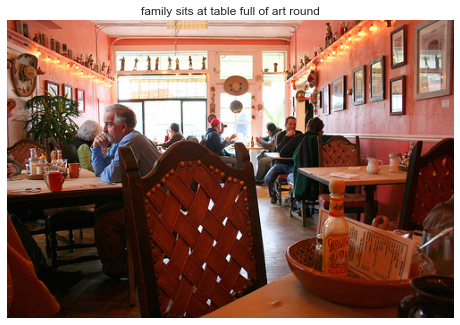

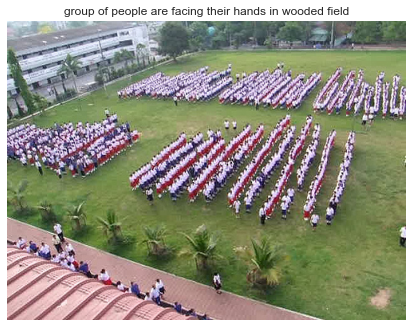

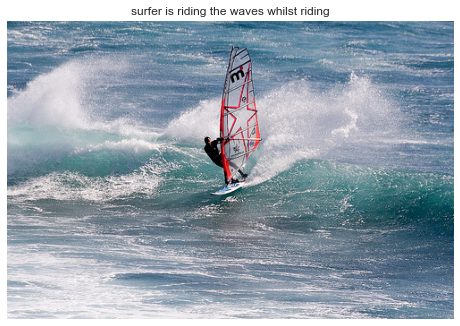

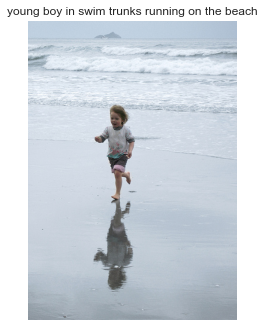

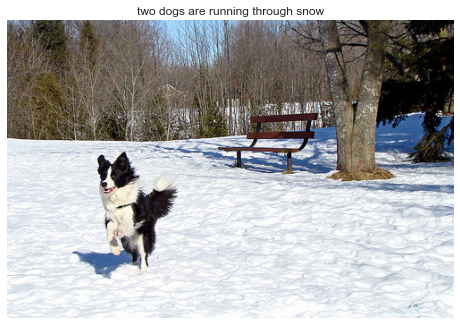

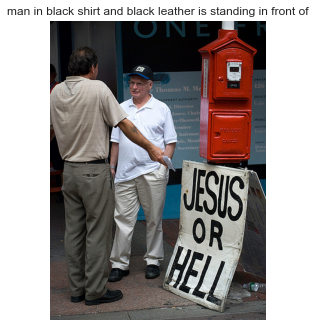

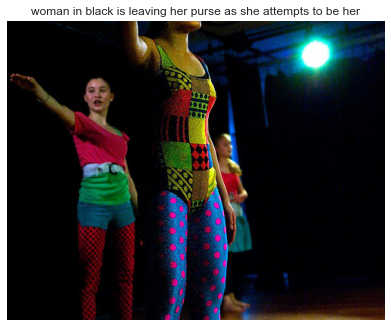

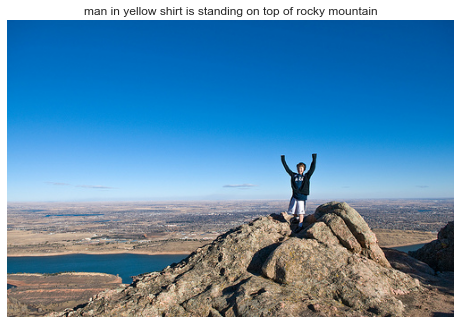

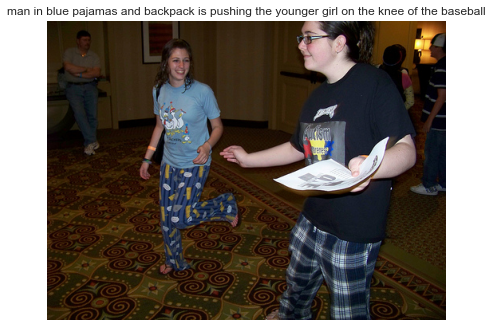

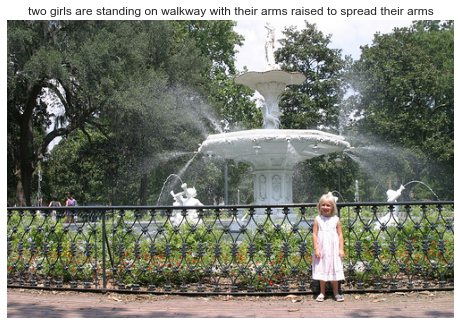

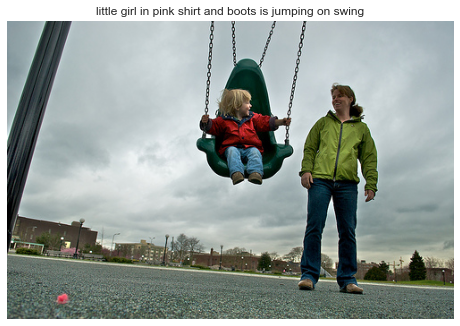

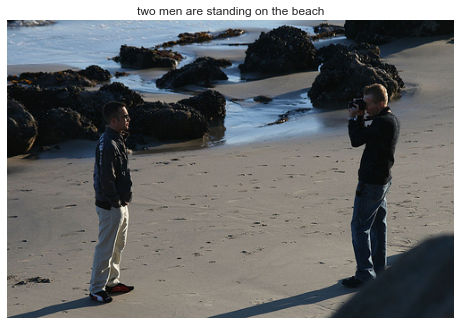

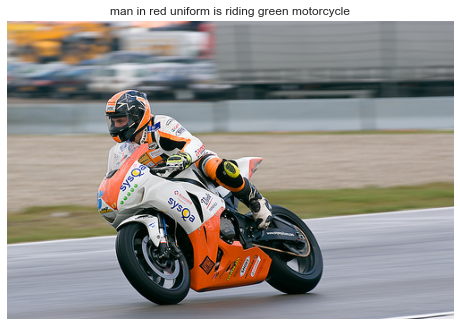

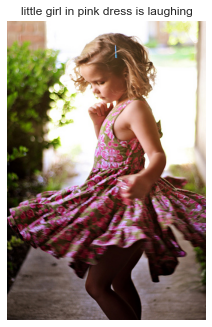

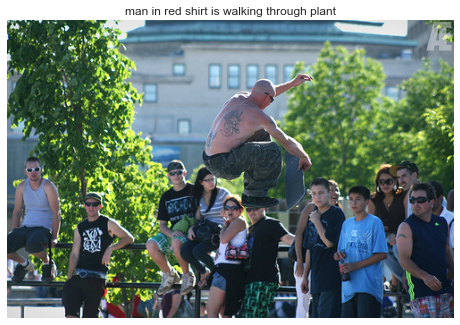

In [107]:
plt.style.use("seaborn")
for i in range(15):
    idx = np.random.randint(0,1000)
    all_img_names = list(encoding_test.keys())
    img_name = all_img_names[idx]
    photo_2048 = encoding_test[img_name].reshape((1,2048))
    
    i = plt.imread("./Flickr_Data/Flickr_Data/Images/"+img_name+".jpg")
    
    caption = predict_caption(photo_2048)
    #print(caption)
    
    plt.title(caption)
    plt.imshow(i)
    plt.axis("off")
    plt.show()